In [18]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path (update this to your actual path)
dataset_path = '/content/drive/MyDrive/CVPR/animals/'
categories = os.listdir(dataset_path)  # Assuming these are your 3 categories

# Verify categories
print("Found categories:", categories)
if len(categories) != 3:
    raise ValueError("Expected 3 categories in the dataset")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found categories: ['panda', 'cats', 'dogs']


In [20]:
# Load and preprocess images
def load_images(dataset_path, categories, max_per_category=100):
    images = []
    labels = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_files = os.listdir(category_path)[:max_per_category]  # Take first 100

        for image_file in tqdm(image_files, desc=f"Loading {category}"):
            image_path = os.path.join(category_path, image_file)
            try:
                # Read and resize image
                image = cv2.imread(image_path)
                image = cv2.resize(image, (64, 64))  # Standard size for processing
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(image)
                labels.append(category)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")

    return np.array(images), np.array(labels)

In [21]:
# Load images and labels
images, labels = load_images(dataset_path, categories)

# Verify we have 100 images per category (300 total)
print("\nDataset statistics:")
for category in categories:
    print(f"{category}: {np.sum(labels == category)} images")

# Flatten images and normalize pixel values
X = images.reshape(images.shape[0], -1) / 255.0  # Flatten and normalize to [0,1]
y = LabelEncoder().fit_transform(labels)  # Convert labels to numerical values


Loading dogs: 100%|██████████| 100/100 [00:00<00:00, 113.13it/s]


Dataset statistics:
panda: 100 images
cats: 100 images
dogs: 100 images


In [22]:
# Create 5 folds with 60 images each (20 per category)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Test k values from 1 to 20
k_values = range(1, 21)
mean_accuracies = []

for k in k_values:
    print(f"\nTesting k = {k}")
    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train KNN classifier with current k value
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        # Predict and calculate accuracy
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)

    # Calculate mean accuracy across folds for this k value
    mean_accuracy = np.mean(fold_accuracies)
    mean_accuracies.append(mean_accuracy)
    print(f"Mean accuracy for k={k}: {mean_accuracy:.4f}")


Testing k = 1
Mean accuracy for k=1: 0.3733

Testing k = 2
Mean accuracy for k=2: 0.3933

Testing k = 3
Mean accuracy for k=3: 0.3767

Testing k = 4
Mean accuracy for k=4: 0.3833

Testing k = 5
Mean accuracy for k=5: 0.3967

Testing k = 6
Mean accuracy for k=6: 0.4100

Testing k = 7
Mean accuracy for k=7: 0.3833

Testing k = 8
Mean accuracy for k=8: 0.3933

Testing k = 9
Mean accuracy for k=9: 0.3933

Testing k = 10
Mean accuracy for k=10: 0.4067

Testing k = 11
Mean accuracy for k=11: 0.3767

Testing k = 12
Mean accuracy for k=12: 0.3933

Testing k = 13
Mean accuracy for k=13: 0.3700

Testing k = 14
Mean accuracy for k=14: 0.3700

Testing k = 15
Mean accuracy for k=15: 0.3767

Testing k = 16
Mean accuracy for k=16: 0.4033

Testing k = 17
Mean accuracy for k=17: 0.4067

Testing k = 18
Mean accuracy for k=18: 0.3967

Testing k = 19
Mean accuracy for k=19: 0.3867

Testing k = 20
Mean accuracy for k=20: 0.3900


(0.0, 1.0)

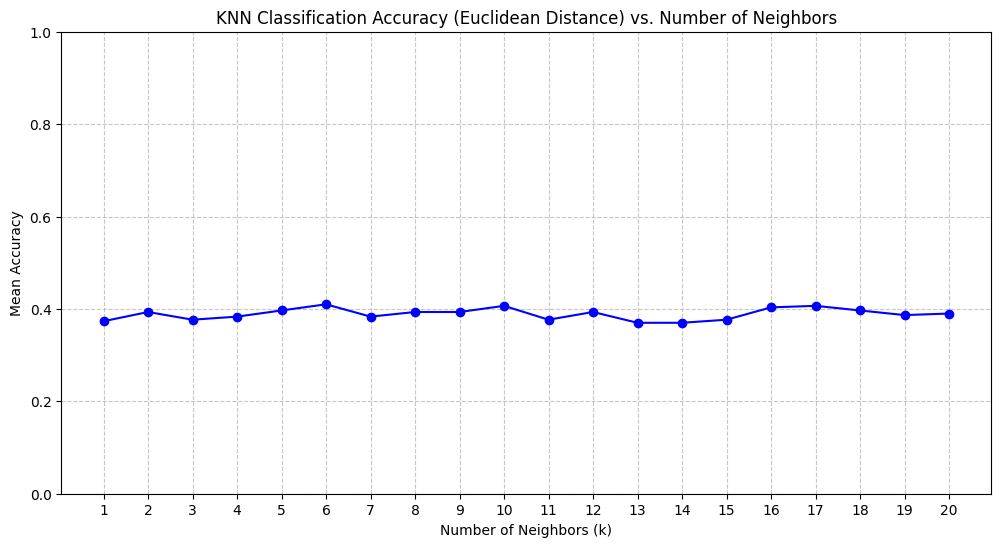

In [23]:
# Plot accuracy vs k values
plt.figure(figsize=(12, 6))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('KNN Classification Accuracy (Euclidean Distance) vs. Number of Neighbors')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

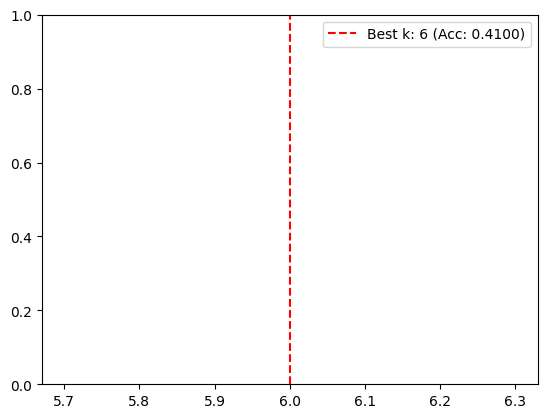


K Value vs Accuracy:
-------------------
k =  1 | Accuracy = 0.3733
k =  2 | Accuracy = 0.3933
k =  3 | Accuracy = 0.3767
k =  4 | Accuracy = 0.3833
k =  5 | Accuracy = 0.3967
k =  6 | Accuracy = 0.4100
k =  7 | Accuracy = 0.3833
k =  8 | Accuracy = 0.3933
k =  9 | Accuracy = 0.3933
k = 10 | Accuracy = 0.4067
k = 11 | Accuracy = 0.3767
k = 12 | Accuracy = 0.3933
k = 13 | Accuracy = 0.3700
k = 14 | Accuracy = 0.3700
k = 15 | Accuracy = 0.3767
k = 16 | Accuracy = 0.4033
k = 17 | Accuracy = 0.4067
k = 18 | Accuracy = 0.3967
k = 19 | Accuracy = 0.3867
k = 20 | Accuracy = 0.3900


In [24]:
# Highlight the best k value
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = max(mean_accuracies)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k: {best_k} (Acc: {best_accuracy:.4f})')
plt.legend()

plt.show()

# Print results in a table
print("\nK Value vs Accuracy:")
print("-------------------")
for k, acc in zip(k_values, mean_accuracies):
    print(f"k = {k:2d} | Accuracy = {acc:.4f}")